In [1]:
!pip install mysql-connector-python

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

import mysql.connector
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Replace these values with your own database credentials
host = "171.244.188.27"
database = "data_sky007v2"
user = "actsonevn"
password = "actsone123!"

# Establish a connection
conn = mysql.connector.connect(
    host=host,
    database=database,
    user=user,
    password=password
)

# Create a cursor
cursor = conn.cursor()
query = "SELECT \
        MAX(CASE WHEN meta_key = '_product_id' THEN meta_value END) AS item_id, \
        MAX(CASE WHEN meta_key = '_qty' THEN meta_value END) AS quantity, \
        p.post_date, oi.order_item_name \
    FROM aowp_posts AS p \
    JOIN aowp_woocommerce_order_items AS oi ON p.ID = oi.order_id \
    JOIN `aowp_woocommerce_order_itemmeta` AS oim ON oi.order_item_id = oim.order_item_id \
    WHERE p.post_date BETWEEN '2015-04-02 00:00:00' AND NOW() \
    GROUP BY p.id"

# Execute the query
cursor.execute(query)
results = cursor.fetchall()
# results = cursor.fetchmany(20)

# Create a DataFrame from the results
columns = ['item_id', 'quantity', 'post_date', 'order_item_name']
df = pd.DataFrame(results, columns=columns)
df



,item_id,quantity,post_date,order_item_name
0,101259,1,2019-01-01 09:46:21,Bbia Last Velvet Lip Tint – #14 Chill Boss
1,34332,1,2019-01-01 10:30:39,Eglips Lively Liquid Glitter Shadow - #04 Meta...
2,101255,1,2019-01-01 11:23:18,Bbia Last Velvet Lip Tint – #11 Calm Boss
3,136270,1,2019-01-01 11:45:44,Bbia Last Velvet Lip Tint - #25 Final Note
4,170926,1,2019-01-01 12:14:45,Eglips Calendar 2019
...,...,...,...,...
1143122,1157238,1,2023-11-27 00:33:23,Bbia Last Velvet Lip Tint -#39 Feign Longing
1143123,872933,1,2023-11-27 00:33:52,Bbia Last Powder Lipstick - #05 Just Try
1143124,835739,1,2023-11-27 00:36:06,Mixsoon Soondy Centella Asiatica Essence 100ml
1143125,486349,1,2023-11-27 00:41:16,Bbia Last Velvet Lip Tint - #36 Feign Cool


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143127 entries, 0 to 1143126
Data columns (total 4 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   item_id          1141358 non-null  object        
 1   quantity         1141358 non-null  object        
 2   post_date        1143127 non-null  datetime64[ns]
 3   order_item_name  1143127 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 34.9+ MB


In [5]:
df = df.dropna()
# df['quantity'].fillna(0, inplace=True)

In [6]:
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(df[['quantity']])

IsolationForest(contamination=0.1, n_estimators=50)

In [7]:
df['scores']=model.decision_function(df[['quantity']])
df['anomaly']=model.predict(df[['quantity']])
df

,item_id,quantity,post_date,order_item_name,scores,anomaly
0,101259,1,2019-01-01 09:46:21,Bbia Last Velvet Lip Tint – #14 Chill Boss,0.0,1
1,34332,1,2019-01-01 10:30:39,Eglips Lively Liquid Glitter Shadow - #04 Meta...,0.0,1
2,101255,1,2019-01-01 11:23:18,Bbia Last Velvet Lip Tint – #11 Calm Boss,0.0,1
3,136270,1,2019-01-01 11:45:44,Bbia Last Velvet Lip Tint - #25 Final Note,0.0,1
4,170926,1,2019-01-01 12:14:45,Eglips Calendar 2019,0.0,1
...,...,...,...,...,...,...
1143122,1157238,1,2023-11-27 00:33:23,Bbia Last Velvet Lip Tint -#39 Feign Longing,0.0,1
1143123,872933,1,2023-11-27 00:33:52,Bbia Last Powder Lipstick - #05 Just Try,0.0,1
1143124,835739,1,2023-11-27 00:36:06,Mixsoon Soondy Centella Asiatica Essence 100ml,0.0,1
1143125,486349,1,2023-11-27 00:41:16,Bbia Last Velvet Lip Tint - #36 Feign Cool,0.0,1


In [8]:
anomaly=df.loc[df['anomaly']==-1]
anomaly_index=list(anomaly.index)
anomaly

,item_id,quantity,post_date,order_item_name,scores,anomaly
63,99874,4,2019-01-01 16:26:32,Bbia Lip Ink Tattoo - #08 Fashion Blood,-0.375328,-1
80,101258,2,2019-01-01 19:28:46,Bbia Last Velvet Lip Tint – #14 Chill Boss,-0.218068,-1
95,101256,2,2019-01-01 19:35:09,Bbia Last Velvet Lip Tint – #12 Sweet Boss,-0.218068,-1
108,101257,2,2019-01-01 19:36:32,Bbia Last Velvet Lip Tint – #12 Sweet Boss,-0.218068,-1
162,101257,2,2019-01-01 19:49:37,Bbia Last Velvet Lip Tint – #13 Serious Boss,-0.218068,-1
...,...,...,...,...,...,...
1142933,626515,2,2023-11-26 16:40:55,Bbia Never Die Mascara - #01 Power Black,-0.218068,-1
1142980,1346822,2,2023-11-26 20:25:45,Bbia Last Velvet Lip Tint – #14 Chill Boss,-0.218068,-1
1143053,486349,2,2023-11-26 22:21:27,Bbia Last Velvet Lip Tint - #36 Feign Cool,-0.218068,-1
1143115,1346822,2,2023-11-27 00:19:51,Bbia Last Velvet Lip Tint – #12 Sweet Boss,-0.218068,-1


In [9]:
df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')
outliers_counter = len(df[df['quantity'] > 50])
outliers_counter

1109

In [10]:
print("Accuracy percentage:", 100*list(df['anomaly']).count(-1)/(outliers_counter))

Accuracy percentage: 5338.412984670875


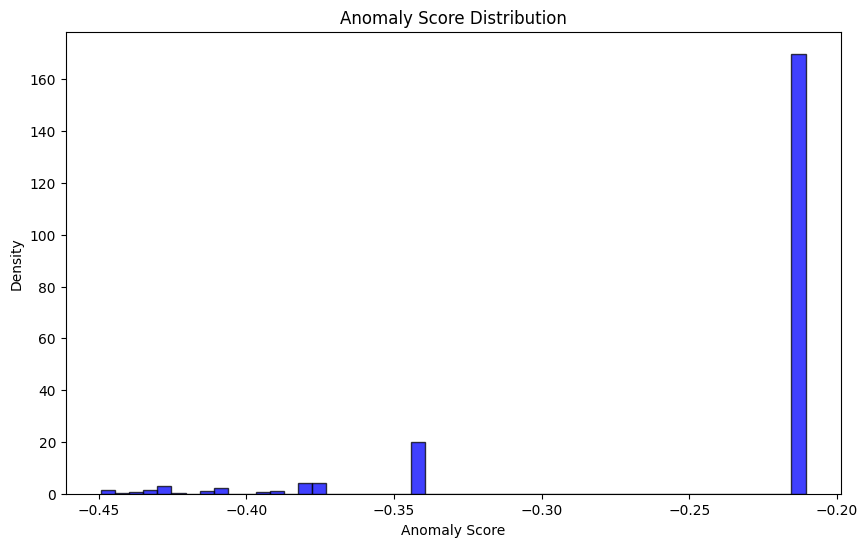

In [ ]:
import matplotlib.pyplot as plt

# Assuming anomaly_scores is a NumPy array or a Pandas Series containing the anomaly scores
plt.figure(figsize=(10, 6))
plt.hist(anomaly['scores'], bins=50, density=True, alpha=0.75, color='blue', edgecolor='black')
plt.title('Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.show()


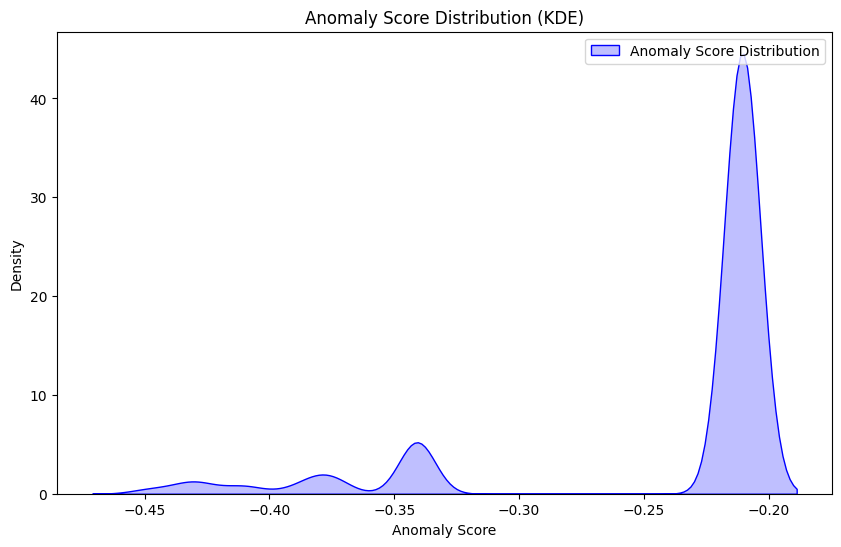

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(anomaly['scores'], fill=True, color='blue', label='Anomaly Score Distribution')
plt.title('Anomaly Score Distribution (KDE)')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.legend()
plt.show()


# Model evaluation

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[      0   59203       0]
 [      0       0       0]
 [      0 1082155       0]]
ROC AUC: 1.0
Precision-Recall AUC: 1.0


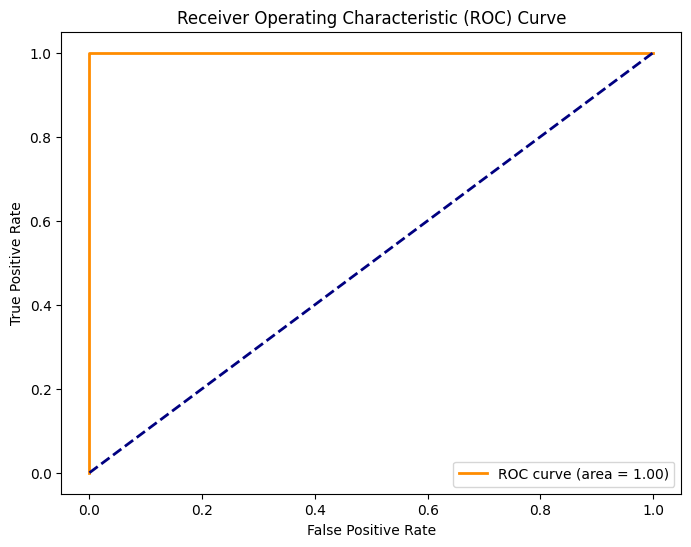

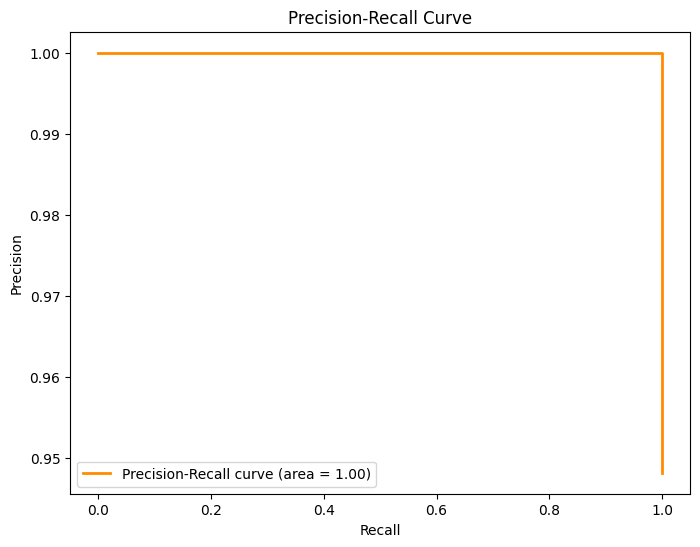

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve


# Define true labels (y_true) and predicted labels (y_pred) based on the 'anomaly' column
y_true = df['anomaly'].values
threshold = 0.5  # You can adjust this threshold based on your problem
y_pred = (df['scores'] > threshold).astype(int)

# Evaluation metrics
precision = precision_score(y_true, y_pred,average='micro')
recall = recall_score(y_true, y_pred ,average='micro')
f1 = f1_score(y_true, y_pred, average='micro')
conf_matrix = confusion_matrix(y_true, y_pred)

# ROC curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y_true, df['scores'])
roc_auc = auc(fpr, tpr)

# Precision-Recall curve and AUC
precision_pr, recall_pr, thresholds_pr = precision_recall_curve(y_true, df['scores'])
pr_auc = auc(recall_pr, precision_pr)

# Print evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("ROC AUC:", roc_auc)
print("Precision-Recall AUC:", pr_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_pr, precision_pr, color='darkorange', lw=2, label='Precision-Recall curve (area = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()



# Statistical Methods: Moving Avg & Standard Deviation

In [10]:
df['moving_avg'] = df['quantity'].rolling(window=3).mean()

In [11]:
df['std_dev'] = df['quantity'].rolling(window=3).std()

In [12]:
df

,item_id,quantity,post_date,order_item_name,scores,anomaly,moving_avg,std_dev
0,101259,1,2019-01-01 09:46:21,Bbia Last Velvet Lip Tint – #14 Chill Boss,0.0,1,NaN,NaN
1,34332,1,2019-01-01 10:30:39,Eglips Lively Liquid Glitter Shadow - #04 Meta...,0.0,1,NaN,NaN
2,101255,1,2019-01-01 11:23:18,Bbia Last Velvet Lip Tint – #11 Calm Boss,0.0,1,1.0,0.0
3,136270,1,2019-01-01 11:45:44,Bbia Last Velvet Lip Tint - #25 Final Note,0.0,1,1.0,0.0
4,170926,1,2019-01-01 12:14:45,Eglips Calendar 2019,0.0,1,1.0,0.0
...,...,...,...,...,...,...,...,...
1143122,1157238,1,2023-11-27 00:33:23,Bbia Last Velvet Lip Tint -#39 Feign Longing,0.0,1,1.0,0.0
1143123,872933,1,2023-11-27 00:33:52,Bbia Last Powder Lipstick - #05 Just Try,0.0,1,1.0,0.0
1143124,835739,1,2023-11-27 00:36:06,Mixsoon Soondy Centella Asiatica Essence 100ml,0.0,1,1.0,0.0
1143125,486349,1,2023-11-27 00:41:16,Bbia Last Velvet Lip Tint - #36 Feign Cool,0.0,1,1.0,0.0


In [13]:
threshold = 1  # Set your threshold based on the standard deviations => capture small deviation, if set higher to capture significant increase => cannot detect anomalies
df['anomaly_statistics'] = (df['quantity'] - df['moving_avg']).abs() > threshold * df['std_dev']

In [14]:
df

,item_id,quantity,post_date,order_item_name,scores,anomaly,moving_avg,std_dev,anomaly_statistics
0,101259,1,2019-01-01 09:46:21,Bbia Last Velvet Lip Tint – #14 Chill Boss,0.0,1,NaN,NaN,False
1,34332,1,2019-01-01 10:30:39,Eglips Lively Liquid Glitter Shadow - #04 Meta...,0.0,1,NaN,NaN,False
2,101255,1,2019-01-01 11:23:18,Bbia Last Velvet Lip Tint – #11 Calm Boss,0.0,1,1.0,0.0,False
3,136270,1,2019-01-01 11:45:44,Bbia Last Velvet Lip Tint - #25 Final Note,0.0,1,1.0,0.0,False
4,170926,1,2019-01-01 12:14:45,Eglips Calendar 2019,0.0,1,1.0,0.0,False
...,...,...,...,...,...,...,...,...,...
1143122,1157238,1,2023-11-27 00:33:23,Bbia Last Velvet Lip Tint -#39 Feign Longing,0.0,1,1.0,0.0,False
1143123,872933,1,2023-11-27 00:33:52,Bbia Last Powder Lipstick - #05 Just Try,0.0,1,1.0,0.0,False
1143124,835739,1,2023-11-27 00:36:06,Mixsoon Soondy Centella Asiatica Essence 100ml,0.0,1,1.0,0.0,False
1143125,486349,1,2023-11-27 00:41:16,Bbia Last Velvet Lip Tint - #36 Feign Cool,0.0,1,1.0,0.0,False


In [15]:
df.anomaly.value_counts()

 1    1082155
-1      59203
Name: anomaly, dtype: int64

In [16]:
df.anomaly_statistics.value_counts()

False    1086639
True       54719
Name: anomaly_statistics, dtype: int64

In [17]:
mismatched_rows = df[df['anomaly'] != df['anomaly_statistics']]

# Display the rows where the values in the 'anomaly' and 'anomaly_statistics' columns do not match
print(mismatched_rows)


         item_id  quantity           post_date  \
0         101259         1 2019-01-01 09:46:21   
1          34332         1 2019-01-01 10:30:39   
2         101255         1 2019-01-01 11:23:18   
3         136270         1 2019-01-01 11:45:44   
4         170926         1 2019-01-01 12:14:45   
...          ...       ...                 ...   
1143122  1157238         1 2023-11-27 00:33:23   
1143123   872933         1 2023-11-27 00:33:52   
1143124   835739         1 2023-11-27 00:36:06   
1143125   486349         1 2023-11-27 00:41:16   
1143126   486349         1 2023-11-27 00:51:36   

                                           order_item_name  scores  anomaly  \
0               Bbia Last Velvet Lip Tint – #14 Chill Boss     0.0        1   
1        Eglips Lively Liquid Glitter Shadow - #04 Meta...     0.0        1   
2                Bbia Last Velvet Lip Tint – #11 Calm Boss     0.0        1   
3               Bbia Last Velvet Lip Tint - #25 Final Note     0.0        1   
4   

In [ ]:
mismatched_rows.to_csv('output_different_patterns', index=False)

In [18]:
anomaly_rows = df[df['anomaly_statistics']]
anomaly_rows


,item_id,quantity,post_date,order_item_name,scores,anomaly,moving_avg,std_dev,anomaly_statistics
63,99874,4,2019-01-01 16:26:32,Bbia Lip Ink Tattoo - #08 Fashion Blood,-0.375328,-1,2.000000,1.732051,True
80,101258,2,2019-01-01 19:28:46,Bbia Last Velvet Lip Tint – #14 Chill Boss,-0.218068,-1,1.333333,0.577350,True
95,101256,2,2019-01-01 19:35:09,Bbia Last Velvet Lip Tint – #12 Sweet Boss,-0.218068,-1,1.333333,0.577350,True
108,101257,2,2019-01-01 19:36:32,Bbia Last Velvet Lip Tint – #12 Sweet Boss,-0.218068,-1,1.333333,0.577350,True
162,101257,2,2019-01-01 19:49:37,Bbia Last Velvet Lip Tint – #13 Serious Boss,-0.218068,-1,1.333333,0.577350,True
...,...,...,...,...,...,...,...,...,...
1142933,626515,2,2023-11-26 16:40:55,Bbia Never Die Mascara - #01 Power Black,-0.218068,-1,1.333333,0.577350,True
1142980,1346822,2,2023-11-26 20:25:45,Bbia Last Velvet Lip Tint – #14 Chill Boss,-0.218068,-1,1.333333,0.577350,True
1143053,486349,2,2023-11-26 22:21:27,Bbia Last Velvet Lip Tint - #36 Feign Cool,-0.218068,-1,1.333333,0.577350,True
1143115,1346822,2,2023-11-27 00:19:51,Bbia Last Velvet Lip Tint – #12 Sweet Boss,-0.218068,-1,1.333333,0.577350,True


In [19]:
import numpy as np

# Assuming df['anomaly_statistics'] is a boolean column indicating anomalies
# Convert True values to -1 and False values to 0
df['anomaly_numeric'] = np.where(df['anomaly_statistics'], -1, 0)

result = df[df['anomaly_numeric'] == df['anomaly']]

# Display the rows where the comparison is True
print(result)


         item_id  quantity           post_date  \
63         99874         4 2019-01-01 16:26:32   
80        101258         2 2019-01-01 19:28:46   
95        101256         2 2019-01-01 19:35:09   
108       101257         2 2019-01-01 19:36:32   
162       101257         2 2019-01-01 19:49:37   
...          ...       ...                 ...   
1142933   626515         2 2023-11-26 16:40:55   
1142980  1346822         2 2023-11-26 20:25:45   
1143053   486349         2 2023-11-26 22:21:27   
1143115  1346822         2 2023-11-27 00:19:51   
1143119   970747         2 2023-11-27 00:24:43   

                                      order_item_name    scores  anomaly  \
63            Bbia Lip Ink Tattoo - #08 Fashion Blood -0.375328       -1   
80         Bbia Last Velvet Lip Tint – #14 Chill Boss -0.218068       -1   
95         Bbia Last Velvet Lip Tint – #12 Sweet Boss -0.218068       -1   
108        Bbia Last Velvet Lip Tint – #12 Sweet Boss -0.218068       -1   
162      Bbia Last 

In [21]:
# Assuming df['anomaly_statistics'] is a boolean column indicating anomalies
# Convert True values to -1 and False values to 0
df['anomaly_numeric'] = np.where(df['anomaly_statistics'], -1, 0)
# Set 'anomaly' column to 0 where the value is 1, else keep the original value
df.loc[df['anomaly'] == 1, 'anomaly'] = 0
result_false = df[~(df['anomaly_numeric'] == df['anomaly'])]
result_false


,item_id,quantity,post_date,order_item_name,scores,anomaly,moving_avg,std_dev,anomaly_statistics,anomaly_numeric
406,115492,2,2019-01-02 09:45:04,Eglips Lively Liquid Glitter Shadow - #03 Whis...,-0.218068,-1,2.000000,1.000000,False,0
408,136270,2,2019-01-02 09:45:51,Bbia Last Velvet Lip Tint – #12 Sweet Boss,-0.218068,-1,1.666667,0.577350,False,0
410,109980,2,2019-01-02 09:46:33,Eglips Blur Powder Pact - Color #21,-0.218068,-1,1.666667,0.577350,False,0
616,90077,3,2019-01-02 12:34:22,Free Shipping,-0.343947,-1,2.000000,1.000000,False,0
676,146609,2,2019-01-02 13:59:42,Eglips Velvet Fit Tint - #03 Vintage Orange,-0.218068,-1,2.000000,1.000000,False,0
...,...,...,...,...,...,...,...,...,...,...
1142599,626515,4,2023-11-25 23:07:18,Bbia Never Die Mascara - #01 Power Black,-0.375328,-1,2.666667,1.527525,False,0
1142635,1346822,2,2023-11-25 23:43:31,Bbia Pop Socket,-0.218068,-1,1.666667,0.577350,False,0
1142636,486353,1,2023-11-25 23:45:14,Bbia Last Velvet Lip Tint - #38 Feign Fine,0.000000,0,1.666667,0.577350,True,-1
1142714,1379428,2,2023-11-26 03:37:48,Trọn bộ Combo 3 Son Kem Lì Bbia Dusk Edition t...,-0.218068,-1,1.666667,0.577350,False,0


In [21]:
# result_diff = df[df['anomaly_numeric'] != df['anomaly']]
# print(result_diff)

         item_id  quantity           post_date  \
0         101259         1 2019-01-01 09:46:21   
1          34332         1 2019-01-01 10:30:39   
2         101255         1 2019-01-01 11:23:18   
3         136270         1 2019-01-01 11:45:44   
4         170926         1 2019-01-01 12:14:45   
...          ...       ...                 ...   
1143122  1157238         1 2023-11-27 00:33:23   
1143123   872933         1 2023-11-27 00:33:52   
1143124   835739         1 2023-11-27 00:36:06   
1143125   486349         1 2023-11-27 00:41:16   
1143126   486349         1 2023-11-27 00:51:36   

                                           order_item_name  scores  anomaly  \
0               Bbia Last Velvet Lip Tint – #14 Chill Boss     0.0        1   
1        Eglips Lively Liquid Glitter Shadow - #04 Meta...     0.0        1   
2                Bbia Last Velvet Lip Tint – #11 Calm Boss     0.0        1   
3               Bbia Last Velvet Lip Tint - #25 Final Note     0.0        1   
4   

In [ ]:
result_false.to_csv('output_different_patterns', index=False)

# Conclusion:
*  Isolation Forest is the best algorithm for detect realtime anomalies because it can capture both small & significant increase of quantity orders even if they're not overall bestsellers
*  Using statistical methods such as std & moving average give lower accuracy => manual set threshold from perspective and experiences => can capture only small changes in specific time, need Empirical Adjustments => difficult applied to data streams
*  Using hybrid methods to compare similar results with items have quantity orders are normal or not in specific times bring about best result => adjust threshold with anomalies performed by Isolation Forest





